# Problem Set 5
Designed by Ben Usman, Sarah Adel Bargal, and Brian Kulis, with help from Kun He and Kate Saenko.

This assignment will introduce you to:

1. implementation of RNN and LSTM
2. training your implemented LSTM
3. deriving multi-modal Restricted Boltzmann Machines

## Part 1: RNN Example

(10 points)

In this example we train an RNN to infer the parameters of a simple dynamical system.
First, we simulate a dynamical system with known parameters (random numbers), and use it to generate outputs. Then, we train an RNN on the generated datapoints, attempting to infer the original parameters.
You are expected to run and study the provided code, which will be helpful for the second part (implementing LSTM).

1. We define a discretized [dynamical system](https://en.wikipedia.org/wiki/Dynamical_system).
At each discrete time $t$, the system observes input $x_t$. The system maintains some "state" $h_t$, which will be updated over time.
Specifically, the states are updated by the following rule: $h_t = \max(0, 1-(Wx_t+h_{t-1}))$, where $W$ is a parameter matrix.
2. In this example, the input data $\{x_t\}$ is randomly generated, and the weight matrix $W$ is also drawn randomly. The system starts from an initial hidden state $h_0$, and runs for $t=1,\ldots,T$.
3. Given the sequence of states $\{h_1,\ldots,h_T\}$, we would like to infer the weights $W$.

To start with, the following code segment generates and displays the data.
Refer to `data_generator.py` for details of data generation.

variable name, shape, min, max: 
h0 (10,) -1.64432771713 0.888951912163
w (10, 10) -2.1527462226 2.62799071843
x (100, 10) -3.25659366864 3.65327854995


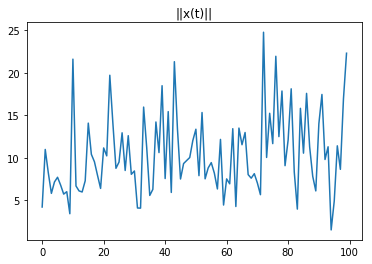

In [1]:
# Here we present sample data generated 
import numpy as np
import data_generator
import matplotlib.pyplot as plt

(h_0, w), x, h = data_generator._build_rnn_testdata_matrix()

print('variable name, shape, min, max: ')
for v, name in zip([h_0, w, x], ['h0', 'w', 'x']):
    print(name, v.shape, np.min(v), np.max(v))
norm_x_t = np.sum(x**2, axis=1)
plt.title('||x(t)||')
plt.plot(np.arange(norm_x_t.shape[0]), norm_x_t)
plt.show()

We model the dynamical system with an RNN. We would like the state generated by the RNN to match the actual observed, and we use L2 loss for this purpose.
This RNN is a *regression* model since it outputs real values.

Below, `build_rnn_regression_model()` gives the model definition, and `train_rnn_with_noise()` generates a batch of data and then runs training on it. 
We corrupt the data generation process with noise, and let the dimensionality of the state $h$ be a free parameter. Therefore, the training function takes two input arguments: `noise_level` and `n_hidden_dim`.   You will later see how varying them affects reconstruction quality.

In [2]:
import datetime
import os
import numpy as np
import tensorflow as tf
from __future__ import print_function

#############################################################################
# RNN model graph
def build_rnn_regression_model(shape):
    # shape is dict with keys:
    # n_steps_per_batch, n_hidden_dim, n_input_dim
    with tf.Graph().as_default() as g:
        # inputs to the dynamical system
        with tf.device("/cpu:0"):
            X = tf.placeholder(tf.float32,
                               [None, shape['n_steps_per_batch'], shape['n_input_dim']])
            # observed state from the dynamical system
            y = tf.placeholder(tf.float32, [None, shape['n_hidden_dim']])

            with tf.variable_scope('weights'):
                # weight matrix
                w = tf.get_variable('w', [shape['n_input_dim'], shape['n_hidden_dim']])
                # initial state
                h_0 = tf.get_variable('h_0', [shape['n_hidden_dim']])

            # for t = 1 to T, update state 
            h_t = h_0
            for t in range(shape['n_steps_per_batch']):
                x_t = X[:, t, :]
                h_t = tf.maximum(0.0, 1 - (tf.matmul(x_t, w) + h_t))
                
            # loss: L2
            loss = tf.nn.l2_loss(h_t - y, name='loss')
            train_op = tf.train.AdamOptimizer(0.1).minimize(loss)
            summ = tf.summary.scalar('loss_sum_%dd' % shape['n_hidden_dim'], loss)
        
    return {'inputs': [X, y], 'loss': loss, 'train_op': train_op, 'summ': summ,
            'weights': {'w': w, 'h_0': h_0}, 'graph': g}

#############################################################################
# Main train loop for an RNN regression model
# 
# This takes synthetic data generated by data_generator.build_dataset()
# the weight matrix W is then inferred with back-prop 
def train_rnn_with_noise(noise_level, n_hidden_dim):
    # generate data
    shapes = dict(n_hidden_dim=n_hidden_dim, n_input_dim=15, n_steps_per_batch=100)
    rnn_dataset = data_generator.build_dataset('rnn', noise=noise_level, **shapes)
    (h0_true, w_true), batched_data = rnn_dataset  # "true" weights
    # build RNN model
    model = build_rnn_regression_model(shapes)
    
    #logdir = './tensorboard/rnn_demo'  # if on Windows
    logdir = './tensorboard/rnn_demo'  # if on Unix
    try:
        os.makedirs(logdir)
    except os.error:
        pass
    # If you want to see the plots, run tensorboard:
    # $ tensorboard --logdir=[your_logdir]
    #
    # If you use SCC, you can forward the 6006 port from the cluster 
    # to your local machine via:
    # $ ssh [SCC_cluster_name] -L 6006:localhost:6006
    time_now = datetime.datetime.now().strftime("%d-%b-%H-%M-%S")
    run_name = 'hidden=%d_noise=%.2f' % (n_hidden_dim, noise_level)
    sum_path = os.path.join(logdir, run_name + '_' + time_now)
    print(sum_path)
    max_iter_i = 0
    with model['graph'].as_default() as g, tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sum_writer = tf.summary.FileWriter(sum_path, g)
        for epoch_i in range(50):
            loss_val, w_dist, h0_dist, iter_i = None, None, None, None
            for iter_i, data_batch in enumerate(batched_data):
                max_iter_i = max(iter_i, max_iter_i)
                global_step = epoch_i*max_iter_i+iter_i
                
                # run training step
                train_feed_dict = dict(zip(model['inputs'], data_batch))
                to_compute = [model['train_op'], model['summ'], model['loss'],
                              model['weights']['w'], model['weights']['h_0']]
                _, summ, loss_val, w_val, h0_val = sess.run(to_compute, train_feed_dict)
                
                # compute reconstruction error
                w_err = np.linalg.norm(w_true-w_val)
                h0_err = np.linalg.norm(h0_true-h0_val)
                
                # for tensorboard
                sum_writer.add_summary(summ, global_step)
                sum_writer.add_summary(tf.Summary(value=[
                    tf.Summary.Value(tag="w_true_dist_%dd" % n_hidden_dim,
                                     simple_value=w_err),
                ]), global_step)
                sum_writer.add_summary(tf.Summary(value=[
                    tf.Summary.Value(tag="h_true_dist_%dd" % n_hidden_dim,
                                     simple_value=h0_err),
                ]), global_step)
                sum_writer.flush()
                
            print('epoch %d, loss=%g, w_err=%g'%(epoch_i, loss_val, w_err))
            if global_step > 200: 
                break  # just train for 200 iterations

ImportError: Traceback (most recent call last):
  File "/share/pkg/tensorflow/r1.0/install/site-packages/tensorflow/python/__init__.py", line 61, in <module>
    from tensorflow.python import pywrap_tensorflow
  File "/share/pkg/tensorflow/r1.0/install/site-packages/tensorflow/python/pywrap_tensorflow.py", line 28, in <module>
    _pywrap_tensorflow = swig_import_helper()
  File "/share/pkg/tensorflow/r1.0/install/site-packages/tensorflow/python/pywrap_tensorflow.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow', fp, pathname, description)
  File "/share/pkg/python/3.6.0/install/lib/python3.6/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/share/pkg/python/3.6.0/install/lib/python3.6/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: /share/pkg/tensorflow/r1.0/install/site-packages/tensorflow/python/_pywrap_tensorflow.so: undefined symbol: PyInstance_Type


Failed to load the native TensorFlow runtime.

See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/get_started/os_setup.md#import_error

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

### Q1.
Now test the RNN wth varying noise levels and hidden dimensionalities.
- For each combination of `n_hidden_dim` and `noise_level`, report the reconstruction error (`w_err`).
- Describe how the hidden dimentionality and the noise level influence reconstruction quality. And briefly explain why.

In [5]:
# Experimenting with different data noise levels and hidden dimentionalities
# We are lucky to know the true hidden dimentionality in our simultaion
for n_hidden_dim in [10, 100, 1000]:
    for noise_level in [0, 0.1, 0.5]:
        print(n_hidden_dim, noise_level)
        train_rnn_with_noise(noise_level, n_hidden_dim)

10 0
./tensorboard/rnn_demo/hidden=10_noise=0.00_27-Apr-14-49-22
epoch 0, loss=22.2892, w_err=2.07589
epoch 1, loss=3.94623, w_err=0.828624
epoch 2, loss=0.523516, w_err=0.288374
epoch 3, loss=0.0672878, w_err=0.106683
epoch 4, loss=0.0168001, w_err=0.0638383
epoch 5, loss=0.0273002, w_err=0.0454453
epoch 6, loss=0.0415354, w_err=0.0359064
epoch 7, loss=0.0409958, w_err=0.0353572
10 0.1
./tensorboard/rnn_demo/hidden=10_noise=0.10_27-Apr-14-49-48
epoch 0, loss=19.2666, w_err=2.3689
epoch 1, loss=4.08486, w_err=1.1221
epoch 2, loss=1.79544, w_err=0.469611
epoch 3, loss=2.00569, w_err=0.432777
epoch 4, loss=2.60183, w_err=0.509764
epoch 5, loss=3.2211, w_err=0.55213
epoch 6, loss=3.45477, w_err=0.605851
epoch 7, loss=3.60187, w_err=0.646565
10 0.5
./tensorboard/rnn_demo/hidden=10_noise=0.50_27-Apr-14-50-16
epoch 0, loss=103.991, w_err=3.62989
epoch 1, loss=49.2646, w_err=2.16078
epoch 2, loss=41.6292, w_err=2.21522
epoch 3, loss=45.0914, w_err=2.15057
epoch 4, loss=46.1693, w_err=2.18158


## Part 2: LSTM implementation

(40 points)

Now let's attempt to recover the weights in dynamical system simulated with an LSTM.  Although LSTMs are already implemented in TensorFlow ([tutorial here](https://www.tensorflow.org/tutorials/recurrent)) ([source here](https://github.com/tensorflow/tensorflow/blob/efe5376f3dec8fcc2bf3299a4ff4df6ad3591c88/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L264)), you will be implementing a simple LSTM from scratch using Tensorflow in this part. 


### Q2. Implement an LSTM 
Implement an LSTM model in an analogous way,  in functions `build_lstm_regression_model()` and `train_lstm_with_noise()` below.
The RNN regression implementation above should give you some ideas.
We already provided an LSTM version of the dynamical system generator in the dataset generator code.

- Specifically, you can follow and implement Eq. 1-6 from [this link](http://deeplearning.net/tutorial/lstm.html) in `build_lstm_regression_model()`. 
You may simplify your code by concatenating $x$ and $h$.
- Afterwards, implement `train_lstm_with_noise()` to train the LSTM and recover the parameters. Compute the reconstruction errors for $W_c$ and $U_c$, which are the parameters used in Eq. 2 in the link.
- For each combination of hidden dimension and noise level, report the reconstruction error (`w_err`, `u_err`) you get from the LSTM.

Note:
- The weights might not get reconstructed correctly in the LSTM case even without noise. (Why?)
Nevertheless, the loss should decrease.

In [6]:
def build_lstm_regression_model(shape):
    # shape is dict with keys:
    # n_steps_per_batch, n_hidden_dim, n_input_dim
    with tf.Graph().as_default() as g:
        # inputs
        X = tf.placeholder(tf.float32,
                           [None, shape['n_steps_per_batch'], shape['n_input_dim']])
        # observed outputs
        y = tf.placeholder(tf.float32, [None, shape['n_hidden_dim']])
        
        #################################################################
        ####################  PUT YOUR CODE HERE   ######################
        # define the parameters in the LSTM (scope: weights)
        # and carry out the computation according to Eq. 1-6 in the link
        with tf.variable_scope('weights'):
           
            
            h_0 = tf.get_variable('h_9', [1, shape['n_hidden_dim']])
            c_0 = tf.get_variable('c_0', [1, shape['n_hidden_dim']])
            w_i = tf.get_variable('w_i', [shape['n_input_dim'], shape['n_hidden_dim']])
            w_c = tf.get_variable('w_c', [shape['n_input_dim'], shape['n_hidden_dim']])
            w_f = tf.get_variable('w_f', [shape['n_input_dim'], shape['n_hidden_dim']])
            w_o = tf.get_variable('w_o', [shape['n_input_dim'], shape['n_hidden_dim']])
            u_i = tf.get_variable('u_i', [shape['n_hidden_dim'], shape['n_hidden_dim']])
            u_c = tf.get_variable('u_c', [shape['n_hidden_dim'], shape['n_hidden_dim']])
            u_f = tf.get_variable('u_f', [shape['n_hidden_dim'], shape['n_hidden_dim']])
            u_o = tf.get_variable('u_o', [shape['n_hidden_dim'], shape['n_hidden_dim']])
            v_o = tf.get_variable('v_o', [shape['n_hidden_dim'], shape['n_hidden_dim']])
            
        h_prev = h_0
        c_prev = c_0
        x_t = X[:, 0, :]
        i_t = tf.sigmoid(tf.matmul(x_t, w_i) + tf.reshape(tf.matmul(h_prev, u_i), [shape['n_hidden_dim']])) #(batch, hidden)
        c_bar_t = tf.tanh(tf.matmul(x_t, w_c) + tf.reshape(tf.matmul(h_prev, u_c), [shape['n_hidden_dim']]))#(batch, hidden)
        f_t = tf.sigmoid(tf.matmul(x_t, w_f) + tf.reshape(tf.matmul(h_prev, u_f), [shape['n_hidden_dim']]))#(batch, hidden)
        c_t = i_t * c_bar_t + f_t * c_prev #(batch, hidden)
        o_t = tf.sigmoid(tf.matmul(x_t, w_o) + tf.reshape(tf.matmul(h_prev, u_o), [shape['n_hidden_dim']]) + \
                         tf.matmul(c_t, v_o)) #(batch, hidden)
        h_t = o_t * tf.tanh(c_t)  #(batch, hidden)
        h_prev = h_t  #(batch, hidden)
        c_prev = c_t  #(batch, hidden)
        for t in range(1, shape['n_steps_per_batch']):
            x_t = X[:, t, :] 
            i_t = tf.sigmoid(tf.matmul(x_t, w_i) + tf.matmul(h_prev, u_i))  #(batch, hidden)
            c_bar_t = tf.tanh(tf.matmul(x_t, w_c) + tf.matmul(h_prev, u_c))  #(batch, hidden)
            f_t = tf.sigmoid(tf.matmul(x_t, w_f) + tf.matmul(h_prev, u_f))  #(batch, hidden)
            c_t = i_t * c_bar_t + c_prev * f_t  #(batch, hidden)
            o_t = tf.sigmoid(tf.matmul(x_t, w_o) + tf.matmul(h_prev, u_o) + tf.matmul(c_t, v_o))  #(batch, hidden)
            h_t = o_t * tf.tanh(c_t) #(batch, hidden)
            h_prev = h_t  #(batch, hidden)
            c_prev = c_t  #(batch, hidden)
                
        output = h_t  # put your result in variable 'output'
        
        #################################################################
        
        # loss and train_op
        loss = tf.nn.l2_loss(output - y, name='loss')
        train_op = tf.train.AdamOptimizer(0.1).minimize(loss)
        summ = tf.summary.scalar('loss_sum_%dd' % shape['n_hidden_dim'], loss)

    return {'inputs': [X, y], 'loss': loss, 'train_op': train_op, 'summ': summ,
            'weights': {'w_c': w_c, 'u_c': u_c}, 
            'graph': g}
    
    
def train_lstm_with_noise(noise_level, n_hidden_dim):
    # generate data and random weights
    shapes = dict(n_hidden_dim=n_hidden_dim, n_input_dim=15, n_steps_per_batch=100)
    weights, batched_data = data_generator.build_dataset('lstm', noise=noise_level, **shapes)
    w_c, u_c = weights[3], weights[7]  # the "true" weights to recover: Wc & Uc (in Eq.2)
    
    # this is the function you implemented
    model = build_lstm_regression_model(shapes)
    
    #logdir = './tensorboard/lstm_demo'  # if on Windows
    logdir = './tensorboard/lstm_demo'  # if on Unix
    try:
        os.makedirs(logdir)
    except os.error:
        pass
    time_now = datetime.datetime.now().strftime("%d-%b-%H-%M-%S")
    run_name = 'hidden=%d_noise=%.2f' % (n_hidden_dim, noise_level)
    sum_path = os.path.join(logdir, run_name + '_' + time_now)
    print(sum_path)
    
    max_iter_i = 0
    with model['graph'].as_default() as g, tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sum_writer = tf.summary.FileWriter(sum_path, g)
        for epoch_i in range(10):  # 10 epochs by default, feel free to change
            loss_val, w_err, u_err, iter_i = None, None, None, None
            for iter_i, data_batch in enumerate(batched_data):
                max_iter_i = max(iter_i, max_iter_i)
                global_step = epoch_i*max_iter_i+iter_i
                
                ###############################################################
                ###################   PUT YOUR CODE HERE   ####################
                train_feed_dict = dict(zip(model['inputs'], data_batch))
                to_compute = [model['train_op'], model['summ'], model['loss'],
                              model['weights']['w_c'], model['weights']['u_c']]
                _, summ, loss_val, w_val, u_val = sess.run(to_compute, train_feed_dict)
            
                
                w_err = np.linalg.norm(w_c - w_val)  # compute them and report
                u_err = np.linalg.norm(u_c - u_val)
                # [optional] you can also do early stopping, e.g. 300 iterations
                # if global_step > 300:
                #    break
                # use sum_writer for tensorboard, see train_rnn_with_noise()
                sum_writer.add_summary(summ, global_step)
                sum_writer.add_summary(tf.Summary(value=[
                    tf.Summary.Value(tag="w_true_dist_%dd" % n_hidden_dim,
                                     simple_value=w_err),
                ]), global_step)
                sum_writer.add_summary(tf.Summary(value=[
                    tf.Summary.Value(tag="h_true_dist_%dd" % n_hidden_dim,
                                     simple_value=u_err),
                ]), global_step)
                sum_writer.flush()
                ###############################################################
            print('epoch %d, loss=%g, w_err=%g'%(epoch_i, loss_val, w_err))
            if global_step > 200: 
                break  # just train for 200 iterations

In [7]:
for n_hidden_dim in [10, 100, 1000]:
    for noise_level in [0, 0.1, 0.5]:
        print(n_hidden_dim, noise_level)
        train_lstm_with_noise(noise_level, n_hidden_dim)
print("lol")

10 0
./tensorboard/lstm_demo/hidden=10_noise=0.00_27-Apr-15-03-45
epoch 0, loss=10.1601, w_err=8.30803
epoch 1, loss=7.91528, w_err=7.21294
epoch 2, loss=5.43464, w_err=6.26387
epoch 3, loss=5.57354, w_err=5.65392
epoch 4, loss=4.79182, w_err=5.58973
epoch 5, loss=5.24243, w_err=5.78585
epoch 6, loss=4.59838, w_err=6.13913
epoch 7, loss=4.10258, w_err=6.15946
10 0.1
./tensorboard/lstm_demo/hidden=10_noise=0.10_27-Apr-15-05-11
epoch 0, loss=13.4522, w_err=9.96355
epoch 1, loss=11.229, w_err=9.01262
epoch 2, loss=8.78038, w_err=8.70215
epoch 3, loss=7.7808, w_err=8.37976
epoch 4, loss=7.8252, w_err=7.9016
epoch 5, loss=8.10587, w_err=7.63238
epoch 6, loss=8.18842, w_err=8.39663
epoch 7, loss=6.66475, w_err=9.0789
10 0.5
./tensorboard/lstm_demo/hidden=10_noise=0.50_27-Apr-15-06-32
epoch 0, loss=9.28773, w_err=10.0977
epoch 1, loss=7.53738, w_err=9.18202
epoch 2, loss=7.31514, w_err=9.48958
epoch 3, loss=8.12374, w_err=9.79273
epoch 4, loss=6.61043, w_err=10.3162
epoch 5, loss=6.2345, w_er

## Part 3: Neural Tolstoy Model (a character-prediction LSTM)

(20 points)

In this part you will train a character prediction LSTM that predicts the next character given previous characters. 
The training data is from the book "War and Peace" by Leo Tolstoy. 

### Q3.
Compared to the LSTM you implemented in the previous part, the main difference in the character prediction LSTM is that it predicts *discrete* outputs (characters, or their indices in the vocabulary), therefore it is a classification model. As you may recall, the usual choice of loss function for classification is softmax + cross entropy.

We have already provided functions for loading the training data. Please define your discrete LSTM in `build_lstm_discrete_prediction_model()`.

Hints: 
- Your LSTM should predict a single character at a time. (That's why it's called a character prediction LSTM.) We are not considering  many-to-many LSTMs here.
- Feeding the previous input into the LSTM should help.

In [3]:
import tolstoy_reader

def get_default_gpu_session(fraction=0.333):
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = fraction
    return tf.Session(config=config)

def run_tolstoy_train(n_hid):
    # generate data
    btg, map_dict, backmap_dict = \
        tolstoy_reader.batch_tolstoy_generator(batch_size=200, seq_size=100)
    shape = dict(n_steps_per_batch=100, n_unique_ids=len(map_dict), n_hidden_dim=n_hid)
    # define LSTM
    model = build_lstm_discrete_prediction_model(shape)
    
    #logdir = './tensorboard/tolstoy'  # if on Windows
    logdir = './tensorboard/tolstoy'  # if on Unix
    try:
        os.makedirs(logdir)
    except os.error:
        pass
    time_now = datetime.datetime.now().strftime("%d-%b-%H-%M-%S")
    run_name = 'hidden=%d' % n_hid
    sum_path = os.path.join(logdir, run_name + '_' + time_now)
    print(sum_path)
    max_iter_i = 0
    with model['graph'].as_default() as g, get_default_gpu_session(0.9) as sess:
        sess.run(tf.global_variables_initializer())
        sum_writer = tf.summary.FileWriter(sum_path, g)
        for epoch_i in range(10):
            for iter_i, data_batch in enumerate(btg):
                max_iter_i = max(iter_i, max_iter_i)
                global_step = epoch_i*max_iter_i+iter_i
                
                # run training step
                train_feed_dict = dict(zip(model['inputs'], data_batch))
                to_compute = [model['train_op'], model['summ'], model['loss']]
                _, summ, loss_val = sess.run(to_compute, train_feed_dict)
                
                # for tensorboard
                sum_writer.add_summary(summ, global_step)
                sum_writer.flush()
                
                # display loss
                if iter_i % 100 == 0:
                    print(loss_val, end=', ')
                if iter_i % 1000:
                    continue
                # test generation
                pred_length = 50
                data_input = next(iter(btg))[0][[0]]
                original_sample = data_input.copy()
                pred_seq = []
                for _ in range(pred_length):
                    pred = sess.run(model['pred'], {model['inputs'][0]: data_input})
                    pred_seq.append(pred[0])
                    data_input = np.roll(data_input, -1, axis=1)
                    data_input[0, -1] = pred[0]
                print('[%d] Input text:' % (iter_i))
                print(''.join([backmap_dict[x] for x in original_sample[0]]))
                print('[%d] Generated continuation:' % (iter_i))
                print(''.join([backmap_dict[x] for x in pred_seq]))
                print(pred_seq)
                print()
                
def build_lstm_discrete_prediction_model(shape):
    # shape is dict with keys:
    # n_steps_per_batch, n_unique_ids, n_hidden_dim
    with tf.Graph().as_default() as g:
        X = tf.placeholder(tf.int64, [None, shape['n_steps_per_batch']])
        y = tf.placeholder(tf.int64, [None])
        
        ################################################################
        ####################   PUT YOUR CODE HERE   ####################
        # define LSTM parameters (scope: weights)
        with tf.variable_scope('weights'):
            h_0 = tf.get_variable('h_9', [1, shape['n_hidden_dim']])
            c_0 = tf.get_variable('c_0', [1, shape['n_hidden_dim']])
            w_i = tf.get_variable('w_i', [1, shape['n_hidden_dim']])
            w_c = tf.get_variable('w_c', [1, shape['n_hidden_dim']])
            w_f = tf.get_variable('w_f', [1, shape['n_hidden_dim']])
            w_o = tf.get_variable('w_o', [1, shape['n_hidden_dim']])
            u_i = tf.get_variable('u_i', [shape['n_hidden_dim'], shape['n_hidden_dim']])
            u_c = tf.get_variable('u_c', [shape['n_hidden_dim'], shape['n_hidden_dim']])
            u_f = tf.get_variable('u_f', [shape['n_hidden_dim'], shape['n_hidden_dim']])
            u_o = tf.get_variable('u_o', [shape['n_hidden_dim'], shape['n_hidden_dim']])
            v_o = tf.get_variable('v_o', [shape['n_hidden_dim'], shape['n_hidden_dim']])
            
        h_prev = h_0
        c_prev = c_0
        for t in range(shape['n_steps_per_batch']):
            x_t = tf.cast(X[:, t], tf.float32)
            i_t = tf.sigmoid(tf.matmul(x_t,w_i) + tf.matmul(h_prev,u_i))  #(batch, hidden)
            c_bar_t = tf.tanh(tf.matmul(x_t, w_c) + tf.matmul(h_prev, u_c))  #(batch, hidden)
            f_t = tf.sigmoid(tf.matmul(x_t, w_f) + tf.matmul(h_prev, u_f))  #(batch, hidden)
            c_t = i_t * c_bar_t + c_prev * f_t  #(batch, hidden)
            o_t = tf.sigmoid(tf.matmul(x_t,w_o) + tf.matmul(h_prev,u_o) + tf.matmul(c_t,v_o))  #(batch, hidden)
            h_t = o_t * tf.tanh(c_t) #(batch, hidden)
            h_prev = h_t  #(batch, hidden)
            c_prev = c_t  #(batch, hidden)
            
        y_logits = h_t  # compute logits for each discrete output
        logits = tf.nn.softmax(y_logits),
        pred = tf.argmax(logits, axis=1)
        y_dict = dict(labels=y, logits=y_logits)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(**y_dict))  # compute loss with respect to (logits, y)
        summ = tf.summary.scalar('loss_summ', loss)
        train_op = tf.train.AdamOptimizer().minimize(loss)
        ################################################################

        # pred, train_op
        
        
        

    return {'inputs': [X, y], 'loss': loss, 'train_op': train_op, 'summ': summ,
            'graph': g, 'pred': pred}

SyntaxError: invalid syntax (<ipython-input-3-a37e44213ba2>, line 94)

Run the LSTM and see what it says! 

In [31]:
hidden = 200
run_tolstoy_train(hidden)

./tensorboard/tolstoy/hidden=200_27-Apr-17-39-44


TypeError: iter() returned non-iterator of type 'GeneratorRestartHandler'

## Part 4: Multi-modal Restricted Boltzmann Machines

(30 points)

- Relevant reading: Goodfellow chapter 20 through 20.8, in particular 20.2 and 20.3. Also see the [lecture notes](https://drive.google.com/file/d/0B8xkaMshuaF9dFVRclo3RENKdUk/view?usp=sharing).

For this question, we will consider designing an unsupervised probability distribution  over two modalities.  Suppose we have data consisting of images and their associated captions, so that each input data point may be thought of as the pair $(t,v)$, where $t = (t_1, ..., t_n)$ is the text data and $v = (v_1, ..., v_m)$ is the visual data.  For simplicity, we will consider both as vector inputs (so, for instance, we will not be considering any two-dimensional convolutions for the visual data); the main difference between the two inputs is that the text input is discrete-valued, where we assume that each $t_i$ can take on $k$ different values, and each visual input is real-valued.

Following our discussion of Restricted Boltzmann Machines (RBMs), we will further consider a hidden layer with **binary** hidden units $(h_1, ..., h_d)$, and define a joint probability distribution over an input data point and a hidden layer.  In particular, let us define two matrices $W_t\in\mathbb{R}^{n\times d}$ and $W_v\in\mathbb{R}^{m\times d}$; these matrices correspond to weights between text input and hidden units, and weights between visual input and hidden units, respectively.  In addition, we have the bias vectors $a$, $b$, and $c$, associated with the text, visual, and hidden units, respectively.
The multi-modal RBM is illustrated below.

<img src="MultimodalRBM.png" width="550">

Next we define the joint probability distribution $p(t,v,h)$ over text inputs, visual inputs, and hidden states.  First we let the energy function be: 

$E(v,t,h) = -t^T W_t h - v^T W_v h - a^T t + (0.5 b^Tb - b^T v + 0.5 v^T v) - c^T h$.

Then let the joint probability be defined as:

$p(v,t,h) = \frac{1}{Z}exp(-E(v,t,h)),$

where $Z$ is the normalizing constant that ensures that the probability distribution is properly normalized to sum/integrate to one.

Our goal is to perform maximum likelihood estimation for the parameters $W_t$, $W_v$, and $c$ (we will assume $a$ and $b$ are fixed and known), given a set of $N$ data points $D = \{(t^{(1)},v^{(1)}), ..., (t^{(N)},v^{(N)})\}$.  As is typical in such settings, we assume that the data in $D$ are i.i.d. samples.

Please write your solutions in the cells below, or hand in a hard copy.
For each question you must show your work to receive full credit.




### Q4.1 

Write down the marginal probability for a single data point $(t^{(1)}, v^{(1)})$, namely $p(t^{(1)}, v^{(1)})$. Treating this probability as the likelihood for a single point, write down the log-likelihood for the entire data set $D$ as a function of the parameters $(W_t, W_v,  c)$.

**Solution:**<br>
$p(v,t,h)\ =\ \frac{1}{Z}exp(-E(v,t,h))$<br>
$p(v,t)\ =\ \frac{\sum_hexp(-E(v,t,h))}{Z}$<br>


$p(v,t,h)\ =\ p(h\ |\ v,t)\ p(v,t)$<br>
$p(h\ |\ v,t)\ =\ \frac{p(v,t,h)}{p(v,t)}\ =\ \frac{exp(-E(v,t,h))}{Z\ p(v,t)}\ =\ \frac{exp[t^T W_t h + v^T W_v h + a^T t - (0.5 b^Tb - b^T v + 0.5 v^T v) + c^T h]}{Z\ p(v,t)}$<br>
$\qquad\ \ \ \ \ =\ \frac{exp[t^T W_t h + v^T W_v h + c^T h]}{Z'}$<br>
$\qquad\ \ \ \ \ =\ \frac{exp[\sum{{(t^T W_t)}_i h_i}+\sum{{(v^T W_v)}_ih_i}+\sum c_i h_i]}{Z'}$<br>
$\qquad\ \ \ \ \ =\ \frac 1{Z'}\prod{exp({(t^T W_t)}_i h_i+{{(v^T W_v)}_ih_i} + c_i h_i)}$<br>
$$
\begin{cases}
p(h_i=1\ |\ v,t)\ &=&\ \frac {\tilde p(h_i=1\ |\ v,t)}{{\tilde p(h_i=1\ |\ v,t)} + {\tilde p(h_i=0\ |\ v,t)}} \\
&=& \frac{exp({(t^T W_t)}_i +{{(v^T W_v)}_i} + c_i)}{exp(0) + {exp({(t^T W_t)}_i+{{(v^T W_v)}_i} + c_i)}}  \\
&=& \sigma({(t^T W_t)}_i +{{(v^T W_v)}_i} + c_i)  \\
p(h_i=0\ |\ v,t)\ &=& \sigma(-{(t^T W_t)}_i - {{(v^T W_v)}_i} - c_i)  \\
\end{cases}
$$

$p(h\ |\ v, t)\ =\prod_{i=1}^{n_h}{\sigma{\left((2h-1)\dot({t^T W_t} - {v^T W_v} - c)\right)}_i}$<br>

$$
\begin{cases}
\begin{array}{rcl}
p(v,t)\ &=& \frac{p(h\ |\ v,t)}{p(v,t,h)}\\
&=&\frac{\prod_{i=1}^{n_h}{\sigma{\left((2h-1)\dot({t^T W_t} - {v^T W_v} - c)\right)}_i}}{\frac{1}{Z}exp(-E(v,t,h))}\ or\ \frac{\sum_hexp(-E(v,t,h))}{Z}\\
\log p(D)\ &=& \sum_{j=0}^{j=n_D}\log p(v^{(i)},t^{(i)})\\
&=&\sum_{j=0}^{j=n_D}\left(\log{\prod_{i=1}^{n_h}{\sigma{\left((2h-1)\dot({t^T W_t} - {v^T W_v} - c)\right)}_i}}-\log{\frac{1}{Z}exp(-E(v,t,h))}\right)^{(j)} \\
&=&\sum_{j=0}^{j=n_D}\left(\log{\prod_{i=1}^{n_h}{\sigma{\left((2h-1)\dot({t^T W_t} - {v^T W_v} - c)\right)}_i}}\right)^{(i)} \\
&=&\sum_{j=0}^{j=n_D}{\sum_{i=1}^{n_h}{\log\Big(\sigma{\left((2h-1)\dot({t^T W_t} - {v^T W_v} - c)\right)_i\Big)}^{(j)}}} \\
\end{array}
\end{cases}
$$

### Q4.2 

Write down the partial derivative of $E(t,v,h)$ with respect to each of the parameters, i.e., each entry of $W_t$, each entry of $W_v$, and each entry of $c$. You can also directly write in matrix/vector forms.


**Solution:**

$E(v,t,h) = -t^T W_t h - v^T W_v h - a^T t + (0.5 b^Tb - b^T v + 0.5 v^T v) - c^T h$<br>
$\left(\frac{\partial E(v,t,h)}{\partial W_t}\right)_{ij}\ =\ t_ih_i$<br>
$\left(\frac{\partial E(v,t,h)}{\partial W_v}\right)_{ij}\ =\ v_ih_i$<br>
$\left(\frac{\partial E(v,t,h)}{\partial c}\right)_{i}\ =\ h_i$<br>

### Q4.3 

Derive the conditional distributions $p(h | v, t)$, $p(v | h)$ and $p(t | h)$, either in elementwise form or in vector form.
Also establish that $v$ and $t$ are conditionally independent given $h$.

**Solution:**<br>
From Q4.1 we already have:<br>
$p(h\ |\ v, t)\ =\prod_{i=1}^{n_h}{\sigma{\left((2h-1)\dot({(t^T W_t)}_i - {(v^T W_v)}_i - c_i)\right)}_i}$<br>

Derive $p(v,t\ |\ h)$ in the same way, then we have:<br>
$p(v,t\ |\ h)\ =\ \frac{p(v,t,h)}{p(h)}\ =\ \frac{exp(-E(v,t,h))}{Z\ p(h)}\ =\ \frac{exp[t^T W_t h + v^T W_v h + a^T t - (0.5 b^Tb - b^T v + 0.5 v^T v) + c^T h]}{Z\ p(h)}$<br>
$\qquad\ \ \ \ \ =\ \frac{exp[t^T W_t h + v^T W_v h + a^T t + b^T v - 0.5 v^T v)]}{Z'}$<br>
$\qquad\ \ \ \ \ =\ \frac{exp[\sum{t_i (W_th)_i} + \sum{v_i (W_vh)_i}+\sum \sum{a_i t_i}+\sum{b_iv_i}-\sum 0.5 v_i^2]}{Z'}$<br>
$\qquad\ \ \ \ \ =\ \frac 1{Z'}\prod_{i=1}^{n_{v,t}}{exp(t_i (W_th)_i + v_i (W_vh)_i+a_i t_i+b_iv_i - 0.5 v_i^2)}$<br>

$$
\begin{cases}
p(v_i=1, t_i=1\ |\ h)\ &=&\ \frac {\tilde p(v_i=1,t_i=1\ |\ h)}{{\tilde p(v_i=1, t_i=1\ |\ h)} + {\tilde p(v_i=0, t_i=0\ |\ h)} + {\tilde p(v_i=0, t_i=1\ |\ h)} + {\tilde p(v_i=1, t_i=0\ |\ h)}} \\
&=& \frac{exp((W_th)_i+(W_vh)_i+a_i +b_i- 0.5)}{exp(a_i+(W_th)_i) + exp(0) + exp((W_th)_i+(W_vh)_i+a_i +b_i- 0.5) + exp((W_vh)_i+b_i- 0.5)}\\
p(v_i=0, t_i=0\ |\ h)\ &=& \frac{exp(0)}{exp(a_i+(W_th)_i) + exp(0) + exp((W_th)_i+(W_vh)_i+a_i +b_i- 0.5) + exp((W_vh)_i+b_i- 0.5)}\\
p(v_i=0, t_i=1\ |\ h)\ &=& \frac{exp(a_i+(W_th)_i)}{exp(a_i+(W_th)_i) + exp(0) + exp((W_th)_i+(W_vh)_i+a_i +b_i- 0.5) + exp((W_vh)_i+b_i- 0.5)}\\
p(v_i=1, t_i=0\ |\ h)\ &=& \frac{exp(b_i-0.5+(W_vh)_i)}{exp(a_i+(W_th)_i) + exp(0) + exp((W_th)_i+(W_vh)_i+a_i +b_i- 0.5) + exp((W_vh)_i+b_i- 0.5)}\\
\end{cases}
$$

$$
\begin{cases}
p(v_i=1\ |\ h)\ &=&\ \frac {{\tilde p(v_i=1,t_i=1\ |\ h)}+{\tilde p(v_i=1,t_i=0\ |\ h)}}{{\tilde p(v_i=1,t_i=1\ |\ h)}+{\tilde p(v_i=1,t_i=0\ |\ h)} + {\tilde p(v_i=0,t_i=1\ |\ h)}+{\tilde p(v_i=0,t_i=0\ |\ h)}} \\
&=& \frac{exp((W_th)_i+(W_vh)_i+a_i +b_i- 0.5) + exp((W_vh)_i+b_i- 0.5)}{exp(a_i+(W_th)_i) + exp(0) + exp((W_th)_i+(W_vh)_i+a_i +b_i- 0.5) + exp((W_vh)_i+b_i- 0.5)}\ =\ \frac{exp((W_vh)_i+b_i- 0.5)}{1 + {exp((W_vh)_i+b_i- 0.5)}} \\
&=& \sigma((W_vh)_i+b_i - 0.5)  \\
p(v_i=0\ |\ h)\ &=& \sigma(-b_i + 0.5-(W_vh)_i)  \\
\end{cases}
$$

$$
\begin{cases}
p(t_i=1\ |\ h)\ &=&\ \frac {{\tilde p(t_i=1,v_i=1\ |\ h)}+{\tilde p(t_i=1,v_i=0\ |\ h)}}{{\tilde p(v_i=1,t_i=1\ |\ h)}+{\tilde p(v_i=1,t_i=0\ |\ h)} + {\tilde p(v_i=0,t_i=1\ |\ h)}+{\tilde p(v_i=0,t_i=0\ |\ h)}} \\
&=& \frac{exp((W_th)_i+(W_vh)_i+a_i +b_i- 0.5)+exp(a_i+(W_th)_i)}{exp(a_i+(W_th)_i) + exp(0) + exp((W_th)_i+(W_vh)_i+a_i +b_i- 0.5) + exp((W_vh)_i+b_i- 0.5)}\ =\ \frac{exp(a_i+(W_th)_i))}{1 + {exp(a_i+(W_th)_i))}} \\
&=& \sigma(a_i+(W_th)_i)  \\
p(t_i=0\ |\ h)\ &=& \sigma(-a_i-(W_th)_i))  \\
\end{cases}
$$

$p(v\ |\ h)\ =\int\prod_{i=1}^{n_v}{\sigma{\left((2v-1)\dot({b - 0.5+W_vh})\right)}_i}dt$<br>
$\qquad\ \ \ \ \ =\ \prod_{i=1}^{n_v}{\sigma{\left((2v-1)\dot({b - 0.5+W_vh})\right)}_i}$<br>

$p(t\ |\ h)\ =\int\prod_{i=1}^{n_v}{\sigma{\left((2t-1)\dot{(a+W_th)}\right)}_i}dv$<br>
$\qquad\ \ \ \ \ =\ \prod_{i=1}^{n_v}{\sigma{\left((2t-1)\dot{(a+W_th)}\right)}_i}$<br>
And $p(v,t\ |\ h)\ =\ p(v\ |\ h)\dot p(t\ |\ h)$. So they are independent.

### Q4.4

Write down the partial derivative of the log-likelihood for $D$ with respect to each of the parameters.

**Solution:**

$\log p(D) = \sum_{j=0}^{j=n_D}{\sum_{i=1}^{n_h}{\log\Big(\sigma{\left((2h-1)\dot(t^T W_t - v^T W_v - c)\right)_i\Big)}^{(j)}}}$<br>
$\frac{\partial{\log p(D)}}{\partial{W_t}}\ =\ \frac{\partial\sum_{j=0}^{j=n_D}\sum_{i=1}^{n_h}\Big(t^T-t^T\sigma \left((2h-1)\dot(t^T W_t - v^T W_v - c)\right)_i\Big)^{(i)}}{\partial{W_t}}\ =\ \sum_{j=0}^{j=n_D}\sum_{i=1}^{n_h}\Big(t^T\sigma \left((1-2h)\dot(t^T W_t - v^T W_v - c)\right)_i\Big)^{(j)}$<br>
$\frac{\partial{\log p(D)}}{\partial{W_v}}\ =\ \frac{\partial\sum_{j=0}^{j=n_D}\sum_{i=1}^{n_h}\Big(v^T-v^T\sigma \left((2h-1)\dot(v^T W_t - v^T W_v - c)\right)_i\Big)^{(i)}}{\partial{W_v}}\ =\ \sum_{j=0}^{j=n_D}\sum_{i=1}^{n_h}\Big(t^T\sigma \left((1-2h)\dot(v^T W_t - v^T W_v - c)\right)_i\Big)^{(j)}$<br>
$\frac{\partial{\log p(D)}}{\partial{c}}\ =\ \frac{\partial\sum_{j=0}^{j=n_D}\sum_{i=1}^{n_h}\Big(-1+\sigma \left((2h-1)\dot(v^T W_t - v^T W_v - c)\right)_i\Big)^{(i)}}{\partial{c}}\ =\ \sum_{j=0}^{j=n_D}\sum_{i=1}^{n_h}\Big(-\sigma \left((1-2h)\dot(v^T W_t - v^T W_v - c)\right)_i\Big)^{(j)}$<br>

### Q4.5 

Extend the contrastive divergence approach for standard RBMs, as discussed in class, to suggest a gradient ascent procedure for learning the parameters of our multi-modal RBM.

**Solution:**<br>
Extend to Gaussian-Bernoulli RBM, $v\in\mathcal{R}^D,\ t\in{1,2,..., K}$<br>
$p(h\ |\ v, t)\ =\prod_{i=1}^{n_h}{\sigma{\left((2h-1)\dot({(t^T W_t)}_i - {(v^T W_v)}_i - c_i)\right)}_i}$<br>
<br><br>$p(v,t\ |\ h)\ =\ \frac{exp[t^T W_t h + v^T W_v h + a^T t - (0.5 b^Tb - b^T v + 0.5 v^T v) + c^T h]}{Z\ p(h)}$<br>
$\qquad\ \ \ \ \ =\ \frac 1{Z'}\prod_{i=1}^{n_{v,t}}{exp(t_i (W_th)_i + v_i (W_vh)_i+a_i t_i+b_iv_i - 0.5 v_i^2)}$<br>
<br><br>$p(v|h)\ =\ \sum_t\frac{exp[t^T W_t h + v^T W_v h + a^T t - (0.5 b^Tb - b^T v + 0.5 v^T v) + c^T h]}{Z\ p(h)}$<br>
$\qquad\ \ \ \ \ =\ \prod_{i=1}^{n_{v,t}}exp(v_i (W_vh)_i+b_iv_i - 0.5 v_i^2)\sum_t\frac 1{Z'}\prod_{i=1}^{n_{v,t}}{exp(t_i (W_th)_i+a_i t_i)}$<br>
$\qquad\ \ \ \ \ =\ \frac 1{Z''(h)}\prod_{i=1}^{n_{v,t}}{exp(v_i (W_vh)_i+b_iv_i - 0.5 v_i^2)}$<br>
$v|h\sim\ \mathcal{N}(v|h; W_vh+b, exp(-0.5*(W_vh+2b)^T(W_vh+2b))$
<br><br>$p(t|h)\ =\ \int_v\frac{exp[t^T W_t h + v^T W_v h + a^T t - (0.5 b^Tb - b^T v + 0.5 v^T v) + c^T h]}{Z\ p(h)}dv$<br>
$\qquad\ \ \ \ \ =\ \prod_{i=1}^{n_{v,t}}exp(t_i (W_th)_i+a_i t_i)\int_v\frac 1{Z'}\prod_{i=1}^{n_{v,t}}{exp(v_i (W_vh)_i+b_iv_i - 0.5 v_i^2)}dv$<br>
$\qquad\ \ \ \ \ =\ \frac 1{Z'''(h)}\prod_{i=1}^{n_{v,t}}{exp(t_i (W_th)_i+a_i t_i)}$<br>
$p(t_i=1|h)\ =\ \frac {exp(t_i (W_th)_i+a_i t_i)}{\sum_{j=0}^{n_{v,t}}exp(t_j (W_th)_j+a_j t_j)}$<br>
